# Implementación en Python del modelo epidemiológico COVID-19 de CDMX

[Modelo publicado por el gobierno de la Ciudad de México](https://modelo.covid19.cdmx.gob.mx/modelo-epidemico)

Robado de la implementación original en Julia de [@ollin18](https://github.com/ollin18/ComplexSystems.jl/blob/master/examples/CDMX_model.ipynb)

[Archivo con los documentos del modelo en el momento de implementar esto](cdmx_archive)

El modelo se define como un sistema de ecuaciones diferenciales ordinarias. Se va a resolver para un rango de tiempo definido.

![ecuaciones.png](img/ecuaciones.png)

Donde:

- S = Susceptibles
- E = Expuestos
- I = Infectados
- L = Contagiados sintomáticos leves
- G = Contagiados sintomáticos graves
- H = Hospitalizados
- ICU = Unidad de Terapia Intensiva
- R = Recuperados
- M = Muertos

![modelo](img/variables.png)

Los parámetros del modelo pueden ser consultados en la página del modelo o en el [archivo que he respaldado](cdmx_archive) por si hay cambios mas adelante. En la implementación del modelo se puede ver los usados en este caso y a qué corresponden.

In [1]:
#https://modelo.covid19.cdmx.gob.mx/modelo-epidemico
#https://github.com/ollin18/ComplexSystems.jl/blob/master/examples/CDMX_model.ipynb

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


VARS = ['susceptibles', 'infecciosos', 'expuestos', 'leve', 'grave', 'hospitalizados', 'uci', 'recuperados', 'muertos']

#por qué necesita esta distribucion?
def degree_dist(p, k_max):
    pk = np.zeros(k_max)
    #print(pk)
    for k in range(k_max-1):
        pk[k+1] = (1 - np.exp(-p)) * np.exp(-p * k)
    #print(pk)
    return pk

Genera una matriz con los 'k_max' casos a probar (simulaciones?)

```
[sus1 sus2 ... susN inf1 inf2 ... infN exp1 exp2 ... expN leve1 ... leve2 ... etc]
```

Inicializa solo con los susceptibles e infectados a partir de datos aleatorios, las demás variables en ceros. Esta matriz es la que se utiliza al integrar para resolver el sistema de ecuaciones.

In [2]:
def make_proportions(compart_num, init_infec):
    """
    Inicializa la matriz de variables del modelo. Quedan en el formato definido en VARS. 
    Cada variable se reporduce por el número de simulaciones.
    """
    susceptible = 1 - prop_inf
    initial = np.array([susceptible, init_infec])
    for n in range(compart_num-2):
        initial = np.vstack((initial, np.zeros(len(init_infec))))
    return initial.flatten()

## Implementación

Esta es la función que implementa el modelo. Su firma debe ser compatible con la firma que espera [`scipy.integrate.odeint`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) (ordinary diferential equations).

- En `x` se recibe la matriz de variables
- En `t` es el paso de tiempo que se está ejecutando (en este caso el modelo no cambia en el tiempo)
- En `k_max` - por clarificar
- En `prop_deg` probabilidad del número de contactos (revisar modelos de redes en vez de deterministas)

El modelo regresa un arreglo en el mismo formato con el resultado de aplicar las funciones a los K_max ejemplos para el tiempo t.

In [3]:
def CDMX(x, t, k_max, prop_deg):
    def iof(ind):
        """IndexOF: solo sirve para sacar el arreglo de la variable de interés"""
        n = VARS.index(ind)
        return x[(n * k_max):((n+1) * k_max)]    

    #Nombres en el modelo de CDMX (2020-05-14)
    R0=2.83         #Tasa de reproducción estimada
    Dinf=2.9        #Tiempo que es infeccioso el paciente
    Dincub=5.2      #Tiempo incubación
    Drl=14          #Tiempo recuperación casos intermedios
    Dhosp=4         #Días entre síntomas y hospitalización
    Drh=12          #Días totales de hospitalización
    Duci=1          #**No especificado en modelo: Dias en UCI
    Druci=7 #10     #**No especificado en modelo: Dias de recuperacion de UCIa
    Dm=8            #**No especificado en modelo: Dias a muerte en UCI
    pgrav=0.138     #Tasa de hospitalización
    puci=0.05       #Tasa de UCI
    pm=0.030        #Tasa de mortalidad
    #Otros:
    #  Tiempo entre incubación y muerte [dias]: 32 
    #  Poblacion susceptible [millones]: 22 (ver en código)
    
    y = np.zeros(len(x))
    k_mult = np.arange(1, k_max+1) * prop_deg
    avg_k = np.sum(k_mult)
    further = np.sum(np.multiply(k_mult, iof('expuestos')))
    th = further / avg_k
    
    for k in range(k_max):
        d_sus = -(R0/Dinf) * iof('infecciosos')[k] * iof('susceptibles')[k]
        d_exp = (R0/Dinf) * iof('infecciosos')[k] * iof('susceptibles')[k] - (1/Dincub)*iof('expuestos')[k]
        d_inf = (1/Dincub) * iof('expuestos')[k] - (1/Dinf) * iof('infecciosos')[k]
        d_leve = (1-pgrav) * (1/Dinf) * iof('infecciosos')[k] - (1/Drl) * iof('leve')[k]
        d_grav = pgrav * (1/Dinf) * iof('infecciosos')[k] - (1/Dhosp) * iof('grave')[k]
        d_hosp = (1/Dhosp) * iof('grave')[k] - (1-puci) * (1/Drh) * iof('hospitalizados')[k] \
            - puci * (1/Duci)*iof('hospitalizados')[k]
        d_uci = puci * (1/Duci) * iof('hospitalizados')[k] - (1-pm) * (1/Druci) * iof('uci')[k] \
            - pm * (1/Dm) * iof('uci')[k]
        d_rec = (1/Drl) * iof('leve')[k] + (1-puci) * (1/Drh) * iof('hospitalizados')[k] \
            + (1-pm) * (1/Druci) * iof('uci')[k]
        d_mue = pm * (1/Dm) * iof('uci')[k]

        y[k] = d_sus
        y[k_max + k] = d_inf
        y[2*k_max + k] = d_exp
        y[3*k_max + k] = d_leve
        y[4*k_max + k] = d_grav
        y[5*k_max + k] = d_hosp
        y[6*k_max + k] = d_uci
        y[7*k_max + k] = d_rec
        y[8*k_max + k] = d_mue
            
    return y

### Ejecución del modelo

k_max define el número de ejemplos aleatorios. Cada uno tiene una variabilidad sobre el contagio (R0) ajustado 
a una ley de potencias (propuesto por @ollin18) y que representa una red con distintos valores de R0.

In [4]:
#numero de "escenarios"
k_max = 200

p = 0.4
infec = np.random.rand(k_max)
all_infec = sum(infec)
prop_inf = infec / all_infec
prop_inf

array([3.59996978e-03, 5.43912369e-04, 1.14763576e-04, 8.95993651e-03,
       3.98668816e-03, 1.78177358e-03, 2.42900831e-04, 9.93709263e-03,
       1.38295542e-03, 5.63139322e-03, 9.09252061e-03, 7.95504116e-03,
       6.09159800e-03, 4.84618752e-03, 1.94534689e-03, 3.00610066e-03,
       4.33562281e-03, 5.21425908e-04, 3.26113904e-03, 2.18505362e-03,
       7.66752285e-03, 8.87365575e-03, 9.87376123e-04, 2.63760888e-03,
       1.18050834e-04, 1.55337273e-04, 7.01579707e-03, 9.14738880e-03,
       7.14829840e-04, 3.09446730e-03, 9.41545200e-03, 7.40023288e-04,
       3.86271878e-03, 3.63974165e-03, 7.94012327e-03, 2.13345416e-03,
       9.16093714e-03, 6.99285788e-03, 8.60600291e-03, 2.36980599e-03,
       3.76259066e-03, 1.09078853e-03, 9.15430293e-03, 1.21790733e-03,
       3.03493431e-03, 2.26102137e-03, 4.36759859e-03, 2.73491174e-03,
       7.46454766e-03, 3.04464386e-03, 1.00147995e-02, 7.44981090e-03,
       1.00567032e-02, 8.49336084e-03, 7.01696433e-03, 7.73492071e-03,
      

In [5]:
np.sum(prop_inf * np.arange(1, k_max+1))

102.13365713810033

Inicialización de la matriz de variables

In [6]:
the_proportions = make_proportions(9, prop_inf)
the_proportions
len(the_proportions)

1800

[0.         0.32967995 0.22099108 0.14813475 0.09929769 0.06656123
 0.04461733 0.02990789 0.02004786 0.01343848]


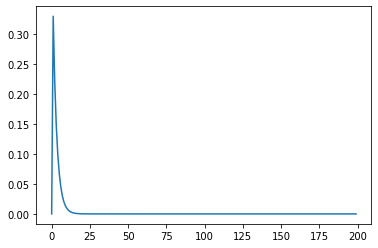

In [7]:
#pd es el parámetro prop_deg del modelo (qué es?)
pd = degree_dist(p, k_max)
print(pd[:10])
#sum(pd)
plt.plot(pd)

In [8]:
np.sum(np.multiply(pd, np.arange(1, k_max+1)))

4.033244781719736

Ejecución del modelo, resuelve el sistema de ecuaciones diferenciales en los tiempos definidos en `t` (días)

In [9]:
t = np.arange(0, 101, 1)
y1 = odeint(CDMX, the_proportions, t, args=(k_max, pd))

In [10]:
y1.shape

(101, 1800)

In [11]:
print(y1[0].shape)
y1[0]

(1800,)


array([0.99640003, 0.99945609, 0.99988524, ..., 0.        , 0.        ,
       0.        ])

In [12]:
susceptibles = [np.sum(np.multiply(ye[:k_max], pd)) for ye in y1]
print(len(susceptibles))
susceptibles

101


[0.9973589032824983,
 0.9951365983792677,
 0.9932575069903774,
 0.9914072917361508,
 0.9894090350231466,
 0.9871498175380005,
 0.9845448614724901,
 0.9815199269960191,
 0.9780027592763786,
 0.9739191774826597,
 0.9691917085398225,
 0.9637397898287099,
 0.9574811123498751,
 0.950333912733522,
 0.9422200852744482,
 0.9330689511130859,
 0.9228214458885056,
 0.911434324328994,
 0.8988838699875354,
 0.8851685365293049,
 0.8703099332471711,
 0.8543517588603224,
 0.8373565485498842,
 0.819400470137843,
 0.8005667919892048,
 0.780938909254902,
 0.7605939239336083,
 0.7395976958635597,
 0.7180020236242631,
 0.6958443028167397,
 0.6731496617927933,
 0.649935263812732,
 0.6262162389793968,
 0.6020125060475197,
 0.5773556187580586,
 0.5522947213172529,
 0.5269007249270525,
 0.5012680216804983,
 0.4755133879897398,
 0.44977220881988267,
 0.42419269455992203,
 0.39892913347564013,
 0.3741353722090101,
 0.3499595035809957,
 0.3265402421818474,
 0.3040048831775656,
 0.2824682347516172,
 0.262031730035

Los resultados se obtienen tras sumar los de cada ejemplo

In [13]:
res = {}
for index, var in enumerate(VARS):
    fr = k_max * index
    to = k_max * (index+1)
    res[var] = [np.sum(np.multiply(ye[fr:to], pd)) for ye in y1] 

## Resultados
### Suceptibles,  Expuestos, Infectados y Recuperados como proporción de la población

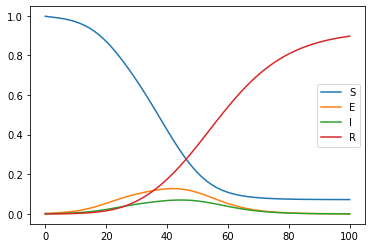

In [14]:
plt.plot(t, res['susceptibles'], label="S")
plt.plot(t, res['expuestos'], label="E")
plt.plot(t, res['infecciosos'], label="I")
plt.plot(t, res['recuperados'], label="R")
plt.legend()

### Evolución de los enfermos, totales por población

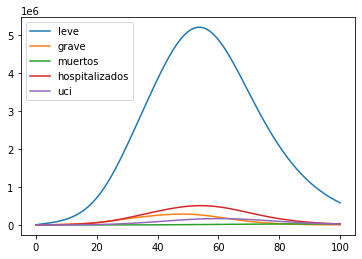

In [15]:
poblacion = 22000000
for var in ['leve', 'grave', 'muertos', 'hospitalizados', 'uci']:
    plt.plot(t, np.multiply(res[var], poblacion), label=var)
plt.legend()

### Uso máximo de UCI

In [16]:
max(res["uci"]) * poblacion

166366.19668268086

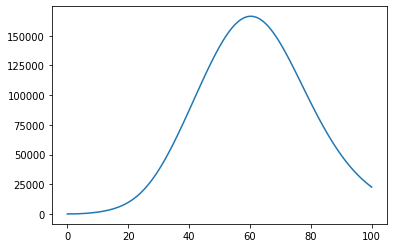

In [17]:
plt.plot(np.multiply(res["uci"], poblacion))

### Muertos al final del periodo

In [18]:
max(res["muertos"]) * poblacion

27807.525633210476